In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# modelos
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


# metricas
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# gestion de train-test
from sklearn.model_selection import train_test_split

# transformaciones
from sklearn.preprocessing import MinMaxScaler


from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

In [2]:
data0 = pd.read_csv("SRC/DATA/water-quality-1.csv")
data0.head()

,Sample ID,Grab ID,Profile ID,Sample Number,Collect DateTime,Depth (m),Site Type,Area,Locator,Site,...,MDL,RDL,Text Value,Sample Info,Steward Note,Replicates,Replicate Of,Method,Date Analyzed,Data Source
0,16316,16316.0,10702,9209019,04/13/1992 12:00:00 AM,1.0,Streams and Rivers,Pipers,KSHZ06,Pipers Creek mouth,...,NaN,NaN,.070||King County Nstream Database/B53311,NaN,NaN,NaN,NaN,none,NaN,KCEL
1,8937,8937.0,37688,7915489,06/20/1979 12:00:00 AM,1.0,Streams and Rivers,Crisp,0321,Crisp Creek mouth at SE Green Valley Rd,...,NaN,NaN,.727||King County Nstream Database/RS2,NaN,NaN,NaN,NaN,NaN,NaN,KCEL
2,137745,137745.0,54368,L58228-1,06/25/2013 08:09:00 AM,1.0,Large Lakes,Lake Union/Ship Canal,0512,Ship Canal above locks,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HYDROLAB,06/25/2013,KCEL
3,131816,131816.0,50605,L55068-6,02/13/2012 09:38:00 AM,1.0,Large Lakes,Lake Union/Ship Canal,0540,Ship Canal near Montlake Bridge,...,0.002,0.005,NaN,NaN,NaN,NaN,NaN,SM4500-P-F,02/15/2012,KCEL
4,82325,82325.0,43896,L52933-87,03/30/2011 02:36:00 PM,4.2,Large Lakes,Lake Washington,0804,Lake Washington north end,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HYDROLAB,NaN,KCEL


In [3]:
data = data0[(data0['Site Type'] == "Large Lakes") | (data0['Site Type'] == 'Streams and Rivers')]
dataPro = data.sample(30000, random_state=2024)
print(dataPro.shape)
#dataPro = data.sample(n=10000, random_state=10)

(30000, 25)


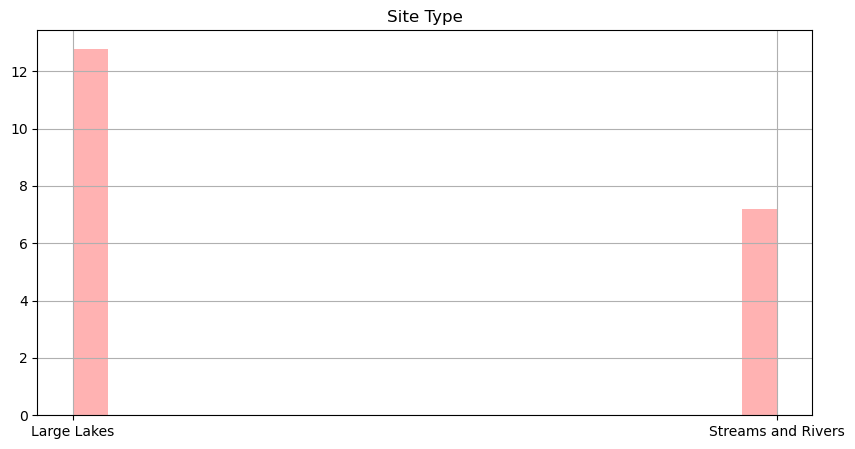

In [4]:
fig = plt.figure(figsize=(10, 5)) 
dataPro['Site Type'].hist(bins=20, density=True, color='red', alpha=0.3)
plt.title('Site Type') 
  

plt.show()

## 1. EDA - Exploratory Data Analysis

Se analizo que la variable Data Source solo tiene un valor, por lo que no aportara nada al modelo y se decide eliminarla

In [5]:
dataPro.drop("Data Source", axis=1, inplace=True)

## 1. Imputación de Datos Faltantes


#### Verificamos porcentaje faltantes por columna

In [6]:
dataPro.isnull().mean()

Sample ID           0.000000
Grab ID             0.282233
Profile ID          0.000000
Sample Number       0.000000
Collect DateTime    0.000000
Depth (m)           0.282233
Site Type           0.000000
Area                0.000000
Locator             0.000000
Site                0.000000
Parameter           0.000000
Value               0.089633
Units               0.000567
QualityId           0.000000
Lab Qualifier       0.879100
MDL                 0.517233
RDL                 0.517533
Text Value          0.815900
Sample Info         1.000000
Steward Note        0.999867
Replicates          0.998467
Replicate Of        0.998767
Method              0.156933
Date Analyzed       0.564533
dtype: float64

### 1.1 - Escala de Variables

In [7]:
categoricas = [col for col in dataPro.columns if(dataPro[col].dtypes == 'object')]
categoricas

['Sample Number',
 'Collect DateTime',
 'Site Type',
 'Area',
 'Locator',
 'Site',
 'Parameter',
 'Units',
 'Lab Qualifier',
 'Text Value',
 'Sample Info',
 'Steward Note',
 'Method',
 'Date Analyzed']

In [8]:
continuas = [col for col in dataPro.columns if((dataPro[col].dtypes in ['int64', 'float64']) and len(dataPro[col].unique()) > 30)]
continuas

['Sample ID',
 'Grab ID',
 'Profile ID',
 'Depth (m)',
 'Value',
 'MDL',
 'RDL',
 'Replicates',
 'Replicate Of']

In [9]:
discretas = [col for col in dataPro.columns if((dataPro[col].dtypes in ['int64', 'float64']) and len(dataPro[col].unique()) <= 30)]
discretas

['QualityId']

## 2. - Balanceo del Dataset

In [10]:
dataPro['Site Type'].value_counts(normalize=True)

Site Type
Large Lakes           0.639433
Streams and Rivers    0.360567
Name: proportion, dtype: float64

Text(0.5, 1.0, 'Site Type')

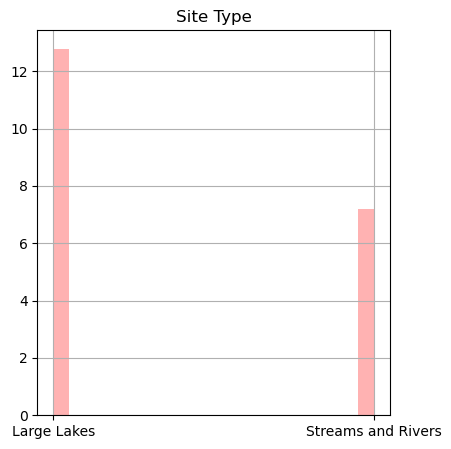

In [11]:
fig = plt.figure(figsize=(10, 5))
plt.subplot(121)
dataPro['Site Type'].hist(bins=20, density=True, color='red', alpha=0.3)
plt.title('Site Type')  

In [12]:
## Seleccion de Target y Features
X = dataPro.drop("Site Type", axis=1) #Feature - lo que voy a usar para predecir
y = dataPro["Site Type"] # target - lo que voy a predecir

### 3.1.- Imputacion de Variables

In [13]:
continuas_con_na = [col for col in continuas if dataPro[col].isnull().mean() > 0]
dataPro[continuas_con_na].isnull().mean() 

Grab ID         0.282233
Depth (m)       0.282233
Value           0.089633
MDL             0.517233
RDL             0.517533
Replicates      0.998467
Replicate Of    0.998767
dtype: float64

In [14]:
continuas_con_na = [col for col in continuas_con_na if dataPro[col].isnull().mean() > 0.5]
dataPro[continuas_con_na].isnull().mean() 

MDL             0.517233
RDL             0.517533
Replicates      0.998467
Replicate Of    0.998767
dtype: float64

In [15]:
dataPro.drop(continuas_con_na, axis=1, inplace=True)

In [16]:
continuas = [col for col in dataPro.columns if((dataPro[col].dtypes in ['int64', 'float64']) and len(dataPro[col].unique()) > 30)]
dataPro[continuas].isnull().mean() 

Sample ID     0.000000
Grab ID       0.282233
Profile ID    0.000000
Depth (m)     0.282233
Value         0.089633
dtype: float64

In [17]:

continuas_con_na = [col for col in continuas if dataPro[col].isnull().mean() > 0]
dataPro[continuas_con_na].isnull().mean() 

Grab ID      0.282233
Depth (m)    0.282233
Value        0.089633
dtype: float64

In [18]:
continuas = [col for col in dataPro.columns if((dataPro[col].dtypes in ['int64', 'float64']) and len(dataPro[col].unique()) > 30)]
dataPro[continuas].isnull().mean() 


Sample ID     0.000000
Grab ID       0.282233
Profile ID    0.000000
Depth (m)     0.282233
Value         0.089633
dtype: float64

In [19]:
mean_GrabID = round(dataPro['Grab ID'].mean(), 2)
dataPro['Grab ID'].fillna(mean_GrabID, inplace=True)

median_Depth = round(dataPro['Depth (m)'].median(), 2)
dataPro['Depth (m)'].fillna(median_Depth, inplace=True)

mean_value = round(dataPro['Value'].mean(), 2)
dataPro['Value'].fillna(mean_value, inplace=True)

In [20]:
categoricas_con_na = [col for col in categoricas if dataPro[col].isnull().mean() > 0]
dataPro[categoricas_con_na].isnull().mean() 

categoricas_con_na_eliminar = [col for col in categoricas if dataPro[col].isnull().mean() > 0.2]
dataPro[categoricas_con_na_eliminar].isnull().mean() 

dataPro.drop(categoricas_con_na_eliminar, axis=1, inplace=True)

In [21]:
categoricas = [col for col in dataPro.columns if(dataPro[col].dtypes == 'object')]
categoricas

categoricas_con_na = [col for col in categoricas if dataPro[col].isnull().mean() > 0]
dataPro[categoricas_con_na].isnull().mean() 

dataPro['Area'].fillna('Lake Washington', inplace=True)

dataPro['Units'].fillna('mg/L', inplace=True)

dataPro['Method'].fillna('NONE', inplace=True)

dataPro.isnull().mean()



Sample ID           0.0
Grab ID             0.0
Profile ID          0.0
Sample Number       0.0
Collect DateTime    0.0
Depth (m)           0.0
Site Type           0.0
Area                0.0
Locator             0.0
Site                0.0
Parameter           0.0
Value               0.0
Units               0.0
QualityId           0.0
Method              0.0
dtype: float64

### 3.2.- Codificacion de Variables Categóricas

Para todas las variables excepto  **Site Type** aplicamos una codificacion por frecuencia

Para todas las variables excepto **Site Type** aplicamos una codificacion por frecuencia

In [22]:
for colName in categoricas:
    if(colName not in ["Site Type"]):
        encoder_dict = dataPro[colName].value_counts().to_dict()
        dataPro[colName]=dataPro[colName].map(encoder_dict)


### 3.2.2- Codificacion de Variable Target (Site Type)

In [23]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

dataPro["Site Type"] = encoder.fit_transform(dataPro["Site Type"])

### 3.3 - Tratamiento de Outliers

In [24]:
import scipy.stats as stats

In [25]:
# Procedimiento para tratamiento de outliers con 1.5*IQR

for colName in continuas:
    IQR = dataPro[colName].quantile(0.75)-dataPro[colName].quantile(0.25)
    LI = dataPro[colName].quantile(0.25)-1.5*IQR
    LS = dataPro[colName].quantile(0.75)+1.5*IQR

    dataPro[colName] = np.where(dataPro[colName]>LS,LS, 
                                    np.where(dataPro[colName]<LI,LI,dataPro[colName]))


### 4.- Contruccion de Modelos

In [26]:
## Seleccion de Target y Features
X = dataPro.drop("Site Type", axis=1) #Feature - lo que voy a usar para predecir
y = dataPro["Site Type"] # target - lo que voy a predecir

In [27]:
# split para entrenamiento y prueba.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=42, shuffle=True)

In [28]:
# creamos y aplicamos escalado de datos.
scaler = MinMaxScaler()

scaler.fit(X_train) #calculamos el scaler

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### 4.1 - Naive Bayes

In [29]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train_scaled,y_train)

nb_predicts = nb_classifier.predict(X_test_scaled) 
acc = roc_auc_score(nb_predicts,y_test)
print("NB - Roc Auc Score: ",acc)
 

NB - Roc Auc Score:  0.9996889897916232


#### 4.1.1 - Naive Bayes - Hyperparametros

In [30]:
nb_classifier1 = GaussianNB(priors=[0.4, 0.6],var_smoothing=1e-11 )

nb_classifier1.fit(X_train_scaled,y_train)

nb_predicts1 = nb_classifier1.predict(X_test_scaled) 
acc = roc_auc_score(nb_predicts1,y_test)
print("NB - Roc Auc Score: ",acc)

NB - Roc Auc Score:  0.9996889897916232


In [31]:
nb_classifier2 = GaussianNB(priors=[0.3, 0.7],var_smoothing=1e-7 )

nb_classifier2.fit(X_train_scaled,y_train)

nb_predicts2 = nb_classifier2.predict(X_test_scaled) 
acc = roc_auc_score(nb_predicts2,y_test)
print("NB - Roc Auc Score: ",acc)

NB - Roc Auc Score:  0.9996889897916232


In [32]:
nb_classifier3 = GaussianNB(var_smoothing=1e-7 )

nb_classifier3.fit(X_train_scaled,y_train)

nb_predicts3 = nb_classifier3.predict(X_test_scaled) 
acc = roc_auc_score(nb_predicts3,y_test)
print("NB - Roc Auc Score: ",acc)

NB - Roc Auc Score:  0.9996889897916232


In [33]:
nb_classifier4 = GaussianNB(priors=[0.3, 0.7] )

nb_classifier4.fit(X_train_scaled,y_train)

nb_predicts4 = nb_classifier4.predict(X_test_scaled) 
acc = roc_auc_score(nb_predicts4,y_test)
print("NB - Roc Auc Score: ",acc)

NB - Roc Auc Score:  0.9996889897916232


In [34]:
# NB Best.fit
hyper_parameters = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4],
    'priors':[0.3, 0.7,None]
}

# Inicializar el clasificador
nb_classifier = GaussianNB()

# Configuración de la búsqueda de hiperparámetros
nb_hyp_opt = GridSearchCV(estimator=nb_classifier, param_grid=hyper_parameters, cv=5, scoring="roc_auc")

# Entrenar el modelo y buscar los mejores hiperparámetros
nb_hyp_opt.fit(X, y)

# Revisar los mejores hiperparámetros y el mejor modelo
print("Best parameters found: ", nb_hyp_opt.best_params_)
print("Best score achieved: ", nb_hyp_opt.best_score_)

acc = roc_auc_score(nb_predicts4,y_test)
print("NB - Roc Auc Score: ",acc)

Best parameters found:  {'priors': None, 'var_smoothing': 1e-09}
Best score achieved:  1.0
NB - Roc Auc Score:  0.9996889897916232


c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
60 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\jggl_\anaconda3\Lib\site-packages\

#### 4.2 - LDA   

In [35]:
# LDA 
lda = LinearDiscriminantAnalysis()

lda.fit(X_train, y_train)
  
# Verificar las clases predichas
y_pred = lda.predict(X_test_scaled)
print("Clases predichas:", np.unique(y_pred))

# Asegurarse de que haya más de una clase en y_test
if len(np.unique(y_test)) < 2:
    raise ValueError("y_test debe contener al menos dos clases para calcular ROC AUC.")

# Calcular el ROC AUC
y_score = lda.predict_proba(X_test_scaled)[:, 1]
acc = roc_auc_score(y_test, y_score)
print("LDA - ROC AUC Score:", acc)
 

Clases predichas: [1]
LDA - ROC AUC Score: 0.4543791588195731


c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(


In [36]:
# LDA 1
lda1 = LinearDiscriminantAnalysis(solver="lsqr",shrinkage="auto")

lda1.fit(X_train, y_train)
  
# Verificar las clases predichas
y_pred1= lda1.predict(X_test_scaled)
print("Clases predichas:", np.unique(y_pred1))

# Asegurarse de que haya más de una clase en y_test
if len(np.unique(y_test)) < 2:
    raise ValueError("y_test debe contener al menos dos clases para calcular ROC AUC.")

# Calcular el ROC AUC
y_score1 = lda1.predict_proba(X_test_scaled)[:, 1]
acc = roc_auc_score(y_test, y_score1)
print("LDA - ROC AUC Score:", acc)
 

Clases predichas: [1]
LDA - ROC AUC Score: 0.4533277140300528


c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(


In [37]:
# LDA 2
lda2 = LinearDiscriminantAnalysis(solver="eigen",shrinkage= 0.1, priors=[0.4, 0.6], store_covariance=False)

lda2.fit(X_train, y_train)
  
# Verificar las clases predichas
y_pred2= lda2.predict(X_test_scaled)
print("Clases predichas:", np.unique(y_pred2))

# Asegurarse de que haya más de una clase en y_test
if len(np.unique(y_test)) < 2:
    raise ValueError("y_test debe contener al menos dos clases para calcular ROC AUC.")

# Calcular el ROC AUC
y_score2 = lda2.predict_proba(X_test_scaled)[:, 1]
acc = roc_auc_score(y_test, y_score2)
print("LDA - ROC AUC Score:", acc)

Clases predichas: [1]
LDA - ROC AUC Score: 1.0


c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(


In [38]:
# LDA 3
lda3 = LinearDiscriminantAnalysis(solver="eigen",shrinkage= 0.1, priors=[0.4, 0.6], tol=1.0e-2)

lda3.fit(X_train, y_train)
  
# Verificar las clases predichas
y_pred3= lda3.predict(X_test_scaled)
print("Clases predichas:", np.unique(y_pred3))

# Asegurarse de que haya más de una clase en y_test
if len(np.unique(y_test)) < 2:
    raise ValueError("y_test debe contener al menos dos clases para calcular ROC AUC.")

# Calcular el ROC AUC
y_score3 = lda3.predict_proba(X_test_scaled)[:, 1]
acc = roc_auc_score(y_test, y_score3)
print("LDA - ROC AUC Score:", acc)

Clases predichas: [1]
LDA - ROC AUC Score: 1.0


c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(


In [39]:
# LDA 4
lda4 = LinearDiscriminantAnalysis(solver="eigen", priors=[0.4, 0.6], tol=1.0e-9, store_covariance=True)

lda4.fit(X_train, y_train)
  
# Verificar las clases predichas
y_pred4= lda4.predict(X_test_scaled)
print("Clases predichas:", np.unique(y_pred4))

# Asegurarse de que haya más de una clase en y_test
if len(np.unique(y_test)) < 2:
    raise ValueError("y_test debe contener al menos dos clases para calcular ROC AUC.")

# Calcular el ROC AUC
y_score4 = lda4.predict_proba(X_test_scaled)[:, 1]
acc = roc_auc_score(y_test, y_score4)
print("LDA - ROC AUC Score:", acc)

Clases predichas: [1]
LDA - ROC AUC Score: 0.42246394771132517


c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(


In [40]:
# LDA 5
lda5 = LinearDiscriminantAnalysis(solver="svd", priors=[0.3, 0.7], tol=1.0e-9, store_covariance=False, n_components=1)

lda5.fit(X_train, y_train)
  
# Verificar las clases predichas
y_pred5= lda5.predict(X_test_scaled)
print("Clases predichas:", np.unique(y_pred5))

# Asegurarse de que haya más de una clase en y_test
if len(np.unique(y_test)) < 2:
    raise ValueError("y_test debe contener al menos dos clases para calcular ROC AUC.")

# Calcular el ROC AUC
y_score5 = lda5.predict_proba(X_test_scaled)[:, 1]
acc = roc_auc_score(y_test, y_score5)
print("LDA - ROC AUC Score:", acc)

Clases predichas: [1]
LDA - ROC AUC Score: 0.4543791588195731


c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(


In [41]:
# LDA Best.fit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Escalado de datos
    ('classifier', LinearDiscriminantAnalysis())
])

# Configuración de la búsqueda de hiperparámetros
hyper_parameters = {
    'classifier__solver': ['svd', 'lsqr', 'eigen'],
    'classifier__shrinkage': [None, 'auto', 0.1, 0.5, 0.9] if 'lsqr' in ['lsqr', 'eigen'] or 'eigen' in ['lsqr', 'eigen'] else [None],
    'classifier__n_components': [1, 2]
}

lda_hyp_opt = GridSearchCV(estimator=pipeline, param_grid=hyper_parameters, cv=5, scoring='accuracy')

# Entrenar el modelo y buscar los mejores hiperparámetros
lda_hyp_opt.fit(X, y)

# Revisar los mejores hiperparámetros y el mejor modelo
print("Best parameters found: ", lda_hyp_opt.best_params_)
print("Best score achieved: ", lda_hyp_opt.best_score_)

# Calcular el ROC AUC
y_score6 = lda_hyp_opt.predict_proba(X_test_scaled)[:, 1]
acc = roc_auc_score(y_test, y_score6)
print("LDA - ROC AUC Score:", acc)

Best parameters found:  {'classifier__n_components': 1, 'classifier__shrinkage': 'auto', 'classifier__solver': 'lsqr'}
Best score achieved:  0.9916
LDA - ROC AUC Score: 0.4493090683491303


c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
95 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.fi

#### 4.3 Regresión logística

In [42]:
logit = LogisticRegression()
logit.fit(X_train_scaled, y_train) #Entrenamiento del modelo

logit_predicts = logit.predict(X_test_scaled)
 
acc = roc_auc_score(logit_predicts,y_test)
print("RL - Roc Auc Score: ",acc)

RL - Roc Auc Score:  1.0


In [43]:
#logit 1
logit1 = LogisticRegression(C=0.1, penalty='l2')
logit1.fit(X_train_scaled, y_train) #Entrenamiento del modelo

logit_predicts1 = logit1.predict(X_test_scaled)
 
acc = roc_auc_score(logit_predicts1,y_test)
print("RL - Roc Auc Score: ",acc)

RL - Roc Auc Score:  1.0


In [44]:
#logit 2
logit2 = LogisticRegression(C=0.1,tol=1e-2, fit_intercept=True, intercept_scaling=1e-3)
logit2.fit(X_train_scaled, y_train) #Entrenamiento del modelo

logit_predicts2 = logit2.predict(X_test_scaled)
 
acc = roc_auc_score(logit_predicts2,y_test)
print("RL - Roc Auc Score: ",acc)

RL - Roc Auc Score:  0.9914976810546394


In [45]:
#logit 3
logit3 = LogisticRegression(C=0.1,tol=1e-2, fit_intercept=True, intercept_scaling=1e-3, solver="liblinear")
logit3.fit(X_train_scaled, y_train) #Entrenamiento del modelo

logit_predicts3 = logit3.predict(X_test_scaled)
 
acc = roc_auc_score(logit_predicts3,y_test)
print("RL - Roc Auc Score: ",acc)

RL - Roc Auc Score:  0.9915939821417599


In [46]:
#logit 4
logit4 = LogisticRegression(C=0.5,tol=1e-2, fit_intercept=True, intercept_scaling=1e-3, solver="liblinear", class_weight="balanced")
logit4.fit(X_train_scaled, y_train) #Entrenamiento del modelo

logit_predicts4 = logit4.predict(X_test_scaled)
 
acc = roc_auc_score(logit_predicts4,y_test)
print("RL - Roc Auc Score: ",acc)

RL - Roc Auc Score:  0.994683014354067


In [47]:
#logit 5
logit5 = LogisticRegression(C=0.5,tol=1e-2, fit_intercept=True, intercept_scaling=1e-3, solver="liblinear", class_weight="balanced", max_iter=200)
logit5.fit(X_train_scaled, y_train) #Entrenamiento del modelo

logit_predicts5 = logit5.predict(X_test_scaled)
 
acc = roc_auc_score(logit_predicts5,y_test)
print("RL - Roc Auc Score: ",acc)

RL - Roc Auc Score:  0.994683014354067


In [48]:
# Definir el espacio de búsqueda de hiperparámetros
hyper_parameters = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],  # Valores de regularización
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Métodos de optimización
    'max_iter': [100, 200, 300],  # Número máximo de iteraciones
    'class_weight': [None, 'balanced'],  # Opciones de peso de clase
    'fit_intercept': [True, False]  # Si se debe ajustar la intercepción
}

# Crear el clasificador de Regresión Logística
logit = LogisticRegression()

# Configurar la búsqueda de hiperparámetros con validación cruzada
logit_grid_search = GridSearchCV(estimator=logit, param_grid=hyper_parameters, cv=5, scoring='roc_auc', error_score='raise')

# Escalar los datos si es necesario (solo si se necesita estandarización)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenamiento del modelo
logit_grid_search.fit(X_train_scaled, y_train)

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", logit_grid_search.best_params_)

# Predecir con el mejor modelo encontrado
best_logit_classifier = logit_grid_search.best_estimator_
logit_predicts = best_logit_classifier.predict(X_test_scaled)

# Calcular el área bajo la curva ROC (ROC AUC) con los mejores hiperparámetros
acc = roc_auc_score(y_test, logit_predicts)
print("Roc_Auc Score:", acc)

c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

Mejores hiperparámetros: {'C': 0.1, 'class_weight': None, 'fit_intercept': True, 'max_iter': 100, 'solver': 'newton-cg'}
Roc_Auc Score: 1.0


c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### 4.4 SVM.

In [49]:
#svm  
svm_classifier = SVC()
svm_classifier.fit(X_train_scaled,y_train)

svm_predicts = svm_classifier.predict(X_test_scaled)

acc = roc_auc_score(svm_predicts,y_test)
print("NB - Roc Auc Score: ",acc)

NB - Roc Auc Score:  0.9993457416976824


In [50]:
#svm 1
svm_classifier1 = SVC(kernel='poly', C=0.5, random_state=42, gamma="scale", degree=5, coef0=0.3, shrinking=True)
svm_classifier1.fit(X_train_scaled,y_train)

svm_predicts1 = svm_classifier1.predict(X_test_scaled)

acc = roc_auc_score(svm_predicts1,y_test)
print("NB - Roc Auc Score: ",acc)

NB - Roc Auc Score:  0.9998855835240275


In [51]:
#svm 2
svm_classifier2 = SVC(kernel='rbf', C=0.8, gamma="scale", degree=8, coef0=0.5, shrinking=True)
svm_classifier2.fit(X_train_scaled,y_train)

svm_predicts2 = svm_classifier2.predict(X_test_scaled)

acc = roc_auc_score(svm_predicts2,y_test)
print("NB - Roc Auc Score: ",acc)

NB - Roc Auc Score:  0.9993457416976824


In [52]:
#svm 3
svm_classifier3 = SVC(kernel='rbf', C=0.8, gamma="scale", degree=8, coef0=0.5, shrinking=True, probability=True)
svm_classifier3.fit(X_train_scaled,y_train)

svm_predicts3 = svm_classifier3.predict(X_test_scaled)

acc = roc_auc_score(svm_predicts3,y_test)
print("NB - Roc Auc Score: ",acc)

NB - Roc Auc Score:  0.9993457416976824


In [53]:
#svm 4
svm_classifier4 = SVC(kernel='rbf', C=0.8, gamma="scale", cache_size=500, degree=8, coef0=0.5, shrinking=True, probability=True)
svm_classifier4.fit(X_train_scaled,y_train)

svm_predicts4 = svm_classifier4.predict(X_test_scaled)

acc = roc_auc_score(svm_predicts4,y_test)
print("NB - Roc Auc Score: ",acc)

NB - Roc Auc Score:  0.9993457416976824


In [54]:
#svm 5
svm_classifier5 = SVC(kernel='rbf', C=0.8, gamma="scale", cache_size=500, degree=8, coef0=0.5, shrinking=True, probability=True, verbose=5)
svm_classifier5.fit(X_train_scaled,y_train)

svm_predicts5 = svm_classifier5.predict(X_test_scaled)

acc = roc_auc_score(svm_predicts5,y_test)
print("NB - Roc Auc Score: ",acc)

[LibSVM]NB - Roc Auc Score:  0.9993457416976824


In [55]:
#svm 6
svm_classifier6 = SVC(C=1.0,
    kernel='rbf',
    gamma='scale',
    degree=3,
    coef0=0.0,
    shrinking=True,
    probability=False,
    tol=1e-3,
    cache_size=200,
    class_weight=None,
    verbose=False,
    max_iter=-1)
svm_classifier6.fit(X_train_scaled,y_train)

svm_predicts6 = svm_classifier6.predict(X_test_scaled)

acc = roc_auc_score(svm_predicts6,y_test)
print("NB - Roc Auc Score: ",acc)

NB - Roc Auc Score:  0.9993457416976824


#### 4.5 Arboles de Decision

In [56]:
#DTC
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train_scaled,y_train)

dt_predicts = dt_classifier.predict(X_test_scaled)

acc = roc_auc_score(dt_predicts,y_test)
print("NB - Roc Auc Score: ",acc)

NB - Roc Auc Score:  1.0


In [57]:
#DTC 1
dt_classifier1 = DecisionTreeClassifier(criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=42,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    class_weight=None,
    ccp_alpha=0.0)
dt_classifier1.fit(X_train_scaled,y_train)

dt_predicts1 = dt_classifier1.predict(X_test_scaled)

acc = roc_auc_score(dt_predicts1,y_test)
print("NB - Roc Auc Score: ",acc)

NB - Roc Auc Score:  1.0


In [58]:
#DTC 2
dt_classifier2 = DecisionTreeClassifier(criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2, 
    min_weight_fraction_leaf=0.0,
    max_features=None, 
    max_leaf_nodes=None,
    min_impurity_decrease=0.0, 
    ccp_alpha=0.0)
dt_classifier2.fit(X_train_scaled,y_train)

dt_predicts2 = dt_classifier2.predict(X_test_scaled)

acc = roc_auc_score(dt_predicts2,y_test)
print("NB - Roc Auc Score: ",acc)

NB - Roc Auc Score:  1.0


In [59]:
#DTC 3
dt_classifier3 = DecisionTreeClassifier(criterion='log_loss',
    splitter='best', 
    min_samples_leaf=1, 
    max_features=None,
    random_state=42,
    max_leaf_nodes=None, 
    class_weight=None,
    ccp_alpha=0.0)
dt_classifier3.fit(X_train_scaled,y_train)

dt_predicts3 = dt_classifier3.predict(X_test_scaled)

acc = roc_auc_score(dt_predicts3,y_test)
print("NB - Roc Auc Score: ",acc)

NB - Roc Auc Score:  1.0


In [60]:
#DTC 4
dt_classifier4 = DecisionTreeClassifier(criterion='entropy',
    splitter='random',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=42,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    class_weight=None,
    ccp_alpha=0.0)
dt_classifier4.fit(X_train_scaled,y_train)

dt_predicts4 = dt_classifier4.predict(X_test_scaled)

acc = roc_auc_score(dt_predicts4,y_test)
print("NB - Roc Auc Score: ",acc)

NB - Roc Auc Score:  1.0


In [61]:
#DTC 5
dt_classifier5 = DecisionTreeClassifier(criterion='entropy',
    splitter='random',
    max_depth=None,
    min_samples_split=0.5,
    min_samples_leaf=5,
    min_weight_fraction_leaf=0.0,
    max_features=None,     
    random_state=42,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    class_weight=None,
    ccp_alpha=0.0)
dt_classifier5.fit(X_train_scaled,y_train)

dt_predicts5 = dt_classifier5.predict(X_test_scaled)

acc = roc_auc_score(dt_predicts5,y_test)
print("NB - Roc Auc Score: ",acc)

NB - Roc Auc Score:  0.9530863712195213


### 4.6 Random Forest

In [62]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_scaled,y_train)

rf_predicts = rf_classifier.predict(X_test_scaled)

acc = roc_auc_score(rf_predicts,y_test)
print("RandomForest - Roc Auc Score: ",acc)

RandomForest - Roc Auc Score:  1.0


In [63]:
#RF 1
rf_classifier1 = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=42,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0
    )
rf_classifier1.fit(X_train_scaled,y_train)

rf_predicts1 = rf_classifier1.predict(X_test_scaled)

acc = roc_auc_score(rf_predicts1,y_test)
print("RandomForest - Roc Auc Score: ",acc)

RandomForest - Roc Auc Score:  1.0


In [64]:
#RF 2
rf_classifier2 = RandomForestClassifier(
    n_estimators=100,
    criterion='entropy', #'gini', 'entropy', 'log_loss'
    max_depth=50,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=20, #int, float, 'auto', 'sqrt', 'log2', None
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=42,
    verbose=0,
    warm_start=False,
    class_weight=None, # dict, 'balanced', None
    ccp_alpha=0.0
    )

rf_classifier2.fit(X_train_scaled,y_train)

rf_predicts2 = rf_classifier2.predict(X_test_scaled)

acc = roc_auc_score(rf_predicts2,y_test)
print("RandomForest - Roc Auc Score: ",acc)

RandomForest - Roc Auc Score:  1.0


In [65]:
#RF 3
rf_classifier3 = RandomForestClassifier(
    n_estimators=50,
    criterion='log_loss', #'gini', 'entropy', 'log_loss'
    max_depth=50,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='log2', #int, float, 'auto', 'sqrt', 'log2', None
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=42,
    verbose=0,
    warm_start=False,
    class_weight='balanced', # dict, 'balanced', None
    ccp_alpha=0.0
    )

rf_classifier3.fit(X_train_scaled,y_train)

rf_predicts3 = rf_classifier3.predict(X_test_scaled)

acc = roc_auc_score(rf_predicts3,y_test)
print("RandomForest - Roc Auc Score: ",acc)

RandomForest - Roc Auc Score:  1.0


In [66]:
#RF 4
rf_classifier4= RandomForestClassifier(
    n_estimators=50,
    criterion='gini', #'gini', 'entropy', 'log_loss'
    max_depth=50, 
    min_weight_fraction_leaf=0.0,
    max_features='sqrt', #int, float, 'auto', 'sqrt', 'log2', None
    max_leaf_nodes=None, 
    bootstrap=False,
    oob_score=False,
    n_jobs=-1,
    random_state=42, 
    warm_start=False,
    class_weight='balanced', # dict, 'balanced', None
    ccp_alpha=0.0
    )

rf_classifier4.fit(X_train_scaled,y_train)

rf_predicts4 = rf_classifier4.predict(X_test_scaled)

acc = roc_auc_score(rf_predicts4,y_test)
print("RandomForest - Roc Auc Score: ",acc)

RandomForest - Roc Auc Score:  1.0


In [67]:
#RF 5
rf_classifier5 = RandomForestClassifier(
    n_estimators=200,
    criterion='gini', #'gini', 'entropy', 'log_loss'
    max_depth=100, 
    min_weight_fraction_leaf=0.0,
    max_features='sqrt', #int, float, 'auto', 'sqrt', 'log2', None 
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=42,
    verbose=0,
    warm_start=False,
    class_weight='balanced', # dict, 'balanced', None
    ccp_alpha=0.0
    )

rf_classifier5.fit(X_train_scaled,y_train)

rf_predicts5 = rf_classifier5.predict(X_test_scaled)

acc = roc_auc_score(rf_predicts5,y_test)
print("RandomForest - Roc Auc Score: ",acc)

RandomForest - Roc Auc Score:  1.0


### 4.7 QDA – Análisis de Discriminante Cuadrático

In [68]:
#QDA
qda_classifier  = QuadraticDiscriminantAnalysis()
qda_classifier .fit(X_train_scaled,y_train)

qda_predicts = qda_classifier.predict(X_test_scaled)

acc = roc_auc_score(qda_predicts,y_test)
print("RandomForest - Roc Auc Score: ",acc)

RandomForest - Roc Auc Score:  0.9997056362485792


c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [69]:
#QDA 1
qda_classifier1  = QuadraticDiscriminantAnalysis(
    priors=None,            # No especificar probabilidades a priori
    reg_param=0.0,          # Sin regularización
    store_covariance=False, # No almacenar matrices de covarianza
    tol=1e-4                # Tolerancia para descartar componentes
)
qda_classifier1 .fit(X_train_scaled,y_train)

qda_predicts1 = qda_classifier1.predict(X_test_scaled)

acc = roc_auc_score(qda_predicts1,y_test)
print("RandomForest - Roc Auc Score: ",acc)

RandomForest - Roc Auc Score:  0.9997056362485792


c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [70]:
#QDA 2
qda_classifier2  = QuadraticDiscriminantAnalysis(
    priors=[0.4,0.6],            # No especificar probabilidades a priori
    reg_param=0.5,          # Sin regularización
    store_covariance=False, # No almacenar matrices de covarianza
    tol=1e-4                # Tolerancia para descartar componentes
)
qda_classifier2 .fit(X_train_scaled,y_train)

qda_predicts2 = qda_classifier2.predict(X_test_scaled)

acc = roc_auc_score(qda_predicts2,y_test)
print("RandomForest - Roc Auc Score: ",acc)

RandomForest - Roc Auc Score:  0.9652971195759629


c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [71]:
#QDA 3
qda_classifier3  = QuadraticDiscriminantAnalysis(
    priors=[0.3,0.7],            # No especificar probabilidades a priori
    reg_param=0.9,          # Sin regularización
    store_covariance=True, # No almacenar matrices de covarianza
    tol=1e-9               # Tolerancia para descartar componentes
)
qda_classifier3 .fit(X_train_scaled,y_train)

qda_predicts3 = qda_classifier3.predict(X_test_scaled)

acc = roc_auc_score(qda_predicts3,y_test)
print("RandomForest - Roc Auc Score: ",acc)

RandomForest - Roc Auc Score:  0.9204115239145367


c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [72]:
#QDA 4
qda_classifier4  = QuadraticDiscriminantAnalysis(
    priors=[0.3,0.7],            # No especificar probabilidades a priori
    reg_param=1.0,          # Sin regularización
    store_covariance=True, # No almacenar matrices de covarianza
    tol=1e-10             # Tolerancia para descartar componentes
)
qda_classifier4 .fit(X_train_scaled,y_train)

qda_predicts4 = qda_classifier4.predict(X_test_scaled)

acc = roc_auc_score(qda_predicts4,y_test)
print("RandomForest - Roc Auc Score: ",acc)

RandomForest - Roc Auc Score:  0.9059595568595755


c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### 4.8 AdaBoost

In [73]:
# Crear un clasificador AdaBoost
adaboost_classifier = AdaBoostClassifier()
adaboost_classifier .fit(X_train_scaled,y_train)

adaboost_predicts = adaboost_classifier.predict(X_test_scaled)

acc = roc_auc_score(adaboost_predicts,y_test)
print("RandomForest - Roc Auc Score: ",acc)

RandomForest - Roc Auc Score:  1.0


c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [74]:
# AB 1
adaboost_classifier1 = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=1.0,
    algorithm='SAMME',
    random_state=2024
)
adaboost_classifier1 .fit(X_train_scaled,y_train)

adaboost_predicts1 = adaboost_classifier1.predict(X_test_scaled)

acc = roc_auc_score(adaboost_predicts1,y_test)
print("RandomForest - Roc Auc Score: ",acc)

RandomForest - Roc Auc Score:  1.0


In [75]:
# AB 2
adaboost_classifier2 = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=2),
    n_estimators=200,
    learning_rate=1.0,
    algorithm='SAMME',
    random_state=2024
)
adaboost_classifier2 .fit(X_train_scaled,y_train)

adaboost_predicts2 = adaboost_classifier2.predict(X_test_scaled)

acc = roc_auc_score(adaboost_predicts2,y_test)
print("RandomForest - Roc Auc Score: ",acc)

RandomForest - Roc Auc Score:  1.0


In [76]:
# AB 3
adaboost_classifier3 = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3),
    n_estimators=200,
    learning_rate=0.8,
    algorithm='SAMME.R',
    random_state=2024
)
adaboost_classifier3 .fit(X_train_scaled,y_train)

adaboost_predicts3 = adaboost_classifier3.predict(X_test_scaled)

acc = roc_auc_score(adaboost_predicts3,y_test)
print("RandomForest - Roc Auc Score: ",acc)

c:\Users\jggl_\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


RandomForest - Roc Auc Score:  1.0


### 4.9 Gradient Boosting

In [77]:
# GB
gb_classifier = GradientBoostingClassifier()
gb_classifier .fit(X_train_scaled,y_train)

gb_predicts = gb_classifier.predict(X_test_scaled)

acc = roc_auc_score(gb_predicts,y_test)
print("RandomForest - Roc Auc Score: ",acc)

RandomForest - Roc Auc Score:  1.0


In [78]:
# GB 1
gb_classifier1 = GradientBoostingClassifier(
    loss='log_loss',        # Función de pérdida
    learning_rate=0.1,      # Tasa de aprendizaje
    n_estimators=100,       # Número de estimadores
    subsample=1.0,          # Submuestreo
    criterion='friedman_mse',# Criterio de calidad
    min_samples_split=2,    # Mínimas muestras para dividir un nodo
    min_samples_leaf=1,     # Mínimas muestras en un nodo hoja
    max_depth=3,            # Profundidad máxima
    max_features=None,      # Todas las características
    random_state=42,        # Estado aleatorio para reproducibilidad
    verbose=1               # Nivel de verbosidad
)
gb_classifier1 .fit(X_train_scaled,y_train)

gb_predicts1 = gb_classifier1.predict(X_test_scaled)

acc = roc_auc_score(gb_predicts1,y_test)
print("RandomForest - Roc Auc Score: ",acc)

      Iter       Train Loss   Remaining Time 
         1           1.1149            1.30s
         2           0.9644            1.53s
         3           0.8412            1.22s
         4           0.7383            1.29s
         5           0.6510            1.65s
         6           0.5761            1.80s
         7           0.5114            1.90s
         8           0.4551            1.82s
         9           0.4059            1.75s
        10           0.3626            1.79s
        20           0.1243            1.55s
        30           0.0447            1.26s
        40           0.0163            0.97s
        50           0.0060            0.76s
        60           0.0022            0.58s
        70           0.0008            0.42s
        80           0.0003            0.27s
        90           0.0001            0.13s
       100           0.0000            0.00s
RandomForest - Roc Auc Score:  1.0


In [79]:
# GB 2
gb_classifier2 = GradientBoostingClassifier(
    loss='exponential',        # Función de pérdida
    learning_rate=0.1,      # Tasa de aprendizaje
    n_estimators=1000,       # Número de estimadores
    subsample=0.8,          # Submuestreo
    criterion='squared_error',# Criterio de calidad
    min_samples_split=2,    # Mínimas muestras para dividir un nodo
    min_samples_leaf=1,     # Mínimas muestras en un nodo hoja
    max_depth=5,            # Profundidad máxima
    max_features=None,      # Todas las características
    random_state=42,        # Estado aleatorio para reproducibilidad
    verbose=1               # Nivel de verbosidad
)
gb_classifier2 .fit(X_train_scaled,y_train)

gb_predicts2 = gb_classifier2.predict(X_test_scaled)

acc = roc_auc_score(gb_predicts2,y_test)
print("RandomForest - Roc Auc Score: ",acc)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.8691           0.0907           37.18s
         2           0.7837           0.0713           27.39s
         3           0.7102           0.0796           30.84s
         4           0.6431           0.0694           28.28s
         5           0.5813           0.0586           25.38s
         6           0.5275           0.0618           21.13s
         7           0.4758           0.0435           20.31s
         8           0.4307           0.0463           23.63s
         9           0.3900           0.0421           23.27s
        10           0.3528           0.0369           22.48s
        20           0.1297           0.0137           18.83s
        30           0.0477           0.0053           19.71s
        40           0.0176           0.0018           18.41s
        50           0.0065           0.0006           16.54s
        60           0.0024           0.0003           15.12s
       

In [80]:
# GB 3
gb_classifier3 = GradientBoostingClassifier(
    loss='log_loss',        # Función de pérdida
    learning_rate=0.3,      # Tasa de aprendizaje
    n_estimators=500,       # Número de estimadores
    subsample=0.6,          # Submuestreo
    criterion='squared_error',# Criterio de calidad 
    max_depth=5,            # Profundidad máxima
    max_features=None,      # Todas las características
    random_state=42,        # Estado aleatorio para reproducibilidad
    verbose=1               # Nivel de verbosidad
)
gb_classifier3 .fit(X_train_scaled,y_train)

gb_predicts3 = gb_classifier3.predict(X_test_scaled)

acc = roc_auc_score(gb_predicts3,y_test)
print("RandomForest - Roc Auc Score: ",acc)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.7970           0.5072            0.00s
         2           0.5376           0.2566            6.16s
         3           0.3765           0.1618            5.55s
         4           0.2681           0.1072            5.92s
         5           0.1935           0.0749            7.21s
         6           0.1415           0.0541            6.76s
         7           0.1031           0.0373            8.25s
         8           0.0757           0.0275            7.64s
         9           0.0556           0.0199            7.25s
        10           0.0410           0.0146            7.53s
        20           0.0020           0.0007            5.38s
        30           0.0001           0.0000            4.99s
        40           0.0000           0.0000            4.56s
        50           0.0000           0.0000            4.29s
        60           0.0000           0.0000            3.92s
       

In [81]:
# GB 4
gb_classifier4 = GradientBoostingClassifier(
    loss='exponential',        # Función de pérdida
    learning_rate=0.7,      # Tasa de aprendizaje
    n_estimators=500,       # Número de estimadores
    subsample=1,          # Submuestreo
    criterion='friedman_mse',# Criterio de calidad 
    max_depth=1,            # Profundidad máxima
    max_features=None,      # Todas las características
    random_state=42,        # Estado aleatorio para reproducibilidad
    verbose=1               # Nivel de verbosidad
)
gb_classifier4.fit(X_train_scaled,y_train)

gb_predicts4 = gb_classifier4.predict(X_test_scaled)

acc = roc_auc_score(gb_predicts4,y_test)
print("RandomForest - Roc Auc Score: ",acc)

      Iter       Train Loss   Remaining Time 
         1           0.4762            1.03s
         2           0.2365            8.73s
         3           0.1174            7.70s
         4           0.0583            7.45s
         5           0.0290            5.95s
         6           0.0144            6.24s
         7           0.0071            6.44s
         8           0.0035            6.28s
         9           0.0018            6.32s
        10           0.0009            6.02s
        20           0.0000            5.50s
        30           0.0000            4.57s
        40           0.0000            3.53s
        50           0.0000            2.90s
        60           0.0000            2.48s
        70           0.0000            2.08s
        80           0.0000            1.86s
        90           0.0000            1.69s
       100           0.0000            1.54s
       200           0.0000            0.77s
       300           0.0000            0.42s
       40

In [82]:
# GB 5
gb_classifier5 = GradientBoostingClassifier(
    loss='exponential',        # Función de pérdida 
    n_estimators=500,       # Número de estimadores
    subsample=1,          # Submuestreo  
    random_state=42,        # Estado aleatorio para reproducibilidad
    verbose=1               # Nivel de verbosidad
)
gb_classifier5.fit(X_train_scaled,y_train)

gb_predicts5 = gb_classifier5.predict(X_test_scaled)

acc = roc_auc_score(gb_predicts5,y_test)
print("RandomForest - Roc Auc Score: ",acc)

      Iter       Train Loss   Remaining Time 
         1           0.8677           15.42s
         2           0.7851           12.89s
         3           0.7104           12.06s
         4           0.6428           10.76s
         5           0.5816           11.73s
         6           0.5263            9.76s
         7           0.4762            9.45s
         8           0.4309           10.17s
         9           0.3899           10.73s
        10           0.3528           10.40s
        20           0.1298            8.11s
        30           0.0477            8.46s
        40           0.0176            7.71s
        50           0.0065            7.02s
        60           0.0024            6.41s
        70           0.0009            6.05s
        80           0.0003            5.75s
        90           0.0001            5.49s
       100           0.0000            5.23s
       200           0.0000            3.31s
       300           0.0000            1.55s
       40

### 4.10 XGBoost

In [83]:
import xgboost as xgb

In [84]:
# XGB 
xgb_classifier = xgb.XGBClassifier()
xgb_classifier .fit(X_train_scaled,y_train)

xgb_predicts = xgb_classifier.predict(X_test_scaled)

acc = roc_auc_score(xgb_predicts,y_test)
print("RandomForest - Roc Auc Score: ",acc)

RandomForest - Roc Auc Score:  1.0


In [85]:
# XGB 1
xgb_classifier1 = xgb.XGBClassifier(
    n_estimators=100,           # Número de árboles
    learning_rate=0.1,          # Tasa de aprendizaje
    max_depth=6,                # Profundidad máxima de los árboles
    min_child_weight=1,         # Peso mínimo en un nodo hijo
    subsample=0.8,              # Fracción de muestras para entrenar cada árbol
    colsample_bytree=0.8,       # Fracción de características para entrenar cada árbol
    gamma=0,                    # Mínima reducción de la función de pérdida para dividir un nodo
    reg_alpha=0,                # Regularización L1
    reg_lambda=1,               # Regularización L2
    scale_pos_weight=1,         # Balance de clases
    objective='binary:logistic', # Función de objetivo para clasificación multiclase
    booster='gbtree',           # Tipo de modelo base
    n_jobs=-1,                  # Usar todos los núcleos disponibles
    random_state=42,            # Estado aleatorio para reproducibilidad
    verbosity=1                 # Nivel de verbosidad
)


xgb_classifier1 .fit(X_train_scaled,y_train)

xgb_predicts1 = xgb_classifier1.predict(X_test_scaled)

acc = roc_auc_score(xgb_predicts1,y_test)
print("RandomForest - Roc Auc Score: ",acc)

RandomForest - Roc Auc Score:  1.0


In [86]:
# XGB 2
xgb_classifier2 = xgb.XGBClassifier(
    n_estimators=200,           # Número de árboles
    learning_rate=0.1,          # Tasa de aprendizaje
    max_depth=6,                # Profundidad máxima de los árboles
    min_child_weight=1,         # Peso mínimo en un nodo hijo
    subsample=0.8,              # Fracción de muestras para entrenar cada árbol
    colsample_bytree=0.8,       # Fracción de características para entrenar cada árbol
    gamma=0,                    # Mínima reducción de la función de pérdida para dividir un nodo
    reg_alpha=0,                # Regularización L1
    reg_lambda=1,               # Regularización L2
    scale_pos_weight=1,         # Balance de clases
    objective='binary:logistic', # Función de objetivo para clasificación multiclase {'binary:logistic', 'multi:softmax', 'multi:softprob', etc.}
    booster='gbtree',           # Tipo de modelo base {'gbtree', 'gblinear', 'dart'}
    n_jobs=-1,                  # Usar todos los núcleos disponibles
    random_state=2024,            # Estado aleatorio para reproducibilidad
    verbosity=2                 # Nivel de verbosidad
)


xgb_classifier2 .fit(X_train_scaled,y_train)

xgb_predicts2 = xgb_classifier2.predict(X_test_scaled)

acc = roc_auc_score(xgb_predicts2,y_test)
print("RandomForest - Roc Auc Score: ",acc)

RandomForest - Roc Auc Score:  1.0


In [87]:
# XGB 3
xgb_classifier3 = xgb.XGBClassifier(
    n_estimators=200,           # Número de árboles
    learning_rate=0.1,          # Tasa de aprendizaje
    max_depth=6,                # Profundidad máxima de los árboles
    min_child_weight=1,         # Peso mínimo en un nodo hijo
    subsample=0.8,              # Fracción de muestras para entrenar cada árbol
    colsample_bytree=0.8,       # Fracción de características para entrenar cada árbol
    gamma=0,                    # Mínima reducción de la función de pérdida para dividir un nodo
    reg_alpha=0,                # Regularización L1
    reg_lambda=1,               # Regularización L2
    scale_pos_weight=1,         # Balance de clases
    objective='binary:logistic', # Función de objetivo para clasificación multiclase {'binary:logistic', 'multi:softmax', 'multi:softprob', etc.}
    booster='gbtree',           # Tipo de modelo base {'gbtree', 'gblinear', 'dart'}
    n_jobs=-1,                  # Usar todos los núcleos disponibles
    random_state=2024,            # Estado aleatorio para reproducibilidad
    verbosity=2                 # Nivel de verbosidad
)


xgb_classifier3 .fit(X_train_scaled,y_train)

xgb_predicts3 = xgb_classifier3.predict(X_test_scaled)

acc = roc_auc_score(xgb_predicts3,y_test)
print("RandomForest - Roc Auc Score: ",acc)

RandomForest - Roc Auc Score:  1.0


In [88]:
# XGB 4
xgb_classifier4 = xgb.XGBClassifier(
    n_estimators=200,           # Número de árboles
    learning_rate=0.1,          # Tasa de aprendizaje    
    reg_alpha=0,                # Regularización L1
    reg_lambda=1,               # Regularización L2
    scale_pos_weight=1,         # Balance de clases
    objective='binary:logistic', # Función de objetivo para clasificación multiclase {'binary:logistic', 'multi:softmax', 'multi:softprob', etc.}
    booster='gbtree',           # Tipo de modelo base {'gbtree', 'gblinear', 'dart'}
    n_jobs=-1,                  # Usar todos los núcleos disponibles
    random_state=2024,            # Estado aleatorio para reproducibilidad
    verbosity=1                 # Nivel de verbosidad
)


xgb_classifier4.fit(X_train_scaled,y_train)

xgb_predicts4 = xgb_classifier4.predict(X_test_scaled)

acc = roc_auc_score(xgb_predicts4,y_test)
print("RandomForest - Roc Auc Score: ",acc)

RandomForest - Roc Auc Score:  1.0


In [89]:
# XGB 5
xgb_classifier5 = xgb.XGBClassifier(
    n_estimators=200,           # Número de árboles
    learning_rate=0.1,          # Tasa de aprendizaje    
    scale_pos_weight=3,         # Balance de clases
    objective='binary:logistic', # Función de objetivo para clasificación multiclase {'binary:logistic', 'multi:softmax', 'multi:softprob', etc.}
    booster='dart',           # Tipo de modelo base {'gbtree', 'gblinear', 'dart'}
    n_jobs=-1,                  # Usar todos los núcleos disponibles
    random_state=2024,            # Estado aleatorio para reproducibilidad
    verbosity=1                 # Nivel de verbosidad
)


xgb_classifier5.fit(X_train_scaled,y_train)

xgb_predicts5 = xgb_classifier5.predict(X_test_scaled)

acc = roc_auc_score(xgb_predicts5,y_test)
print("RandomForest - Roc Auc Score: ",acc)

RandomForest - Roc Auc Score:  1.0


### 4.11 LGBM

In [90]:
import lightgbm as lgb
# Crear un clasificador LightGBM
lgb_classifier = lgb.LGBMClassifier( )

lgb_classifier .fit(X_train_scaled,y_train)

lgb_predicts = lgb_classifier.predict(X_test_scaled)

acc = roc_auc_score(lgb_predicts,y_test)
print("RandomForest - Roc Auc Score: ",acc)


[LightGBM] [Info] Number of positive: 6448, number of negative: 11552
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1653
[LightGBM] [Info] Number of data points in the train set: 18000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358222 -> initscore=-0.583089
[LightGBM] [Info] Start training from score -0.583089
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [92]:
#  LightGBM1
lgb_classifier1 = lgb.LGBMClassifier( 
    n_estimators=100, 
    learning_rate=0.1, 
    num_leaves=20,
    max_depth=10,
    min_child_samples=10,
    subsample=0.8,
    colsample_bytree=0.9,
    reg_alpha=1,
    reg_lambda=0    
    )

lgb_classifier1 .fit(X_train_scaled,y_train)

lgb_predicts1 = lgb_classifier1.predict(X_test_scaled)

acc = roc_auc_score(lgb_predicts1,y_test)
print("RandomForest - Roc Auc Score: ",acc)

[LightGBM] [Info] Number of positive: 6448, number of negative: 11552
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1653
[LightGBM] [Info] Number of data points in the train set: 18000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358222 -> initscore=-0.583089
[LightGBM] [Info] Start training from score -0.583089
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [94]:
#  LightGBM2
lgb_classifier2 = lgb.LGBMClassifier( 
    n_estimators=50, 
    learning_rate=0.01, 
    num_leaves=31,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.1,
    reg_lambda=0.1    
    )

lgb_classifier2 .fit(X_train_scaled,y_train)

lgb_predicts2 = lgb_classifier2.predict(X_test_scaled)

acc = roc_auc_score(lgb_predicts2,y_test)
print("RandomForest - Roc Auc Score: ",acc)

[LightGBM] [Info] Number of positive: 6448, number of negative: 11552
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1653
[LightGBM] [Info] Number of data points in the train set: 18000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358222 -> initscore=-0.583089
[LightGBM] [Info] Start training from score -0.583089
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [95]:
#  LightGBM3
lgb_classifier3 = lgb.LGBMClassifier( 
    n_estimators=200, 
    learning_rate=0.2, 
    num_leaves=40,
    max_depth=-20,
    min_child_samples=30,
    subsample=1.0,
    colsample_bytree=1.0,
    reg_alpha=1,
    reg_lambda=1    
    )

lgb_classifier3 .fit(X_train_scaled,y_train)

lgb_predicts3 = lgb_classifier3.predict(X_test_scaled)

acc = roc_auc_score(lgb_predicts3,y_test)
print("RandomForest - Roc Auc Score: ",acc)

[LightGBM] [Info] Number of positive: 6448, number of negative: 11552
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1653
[LightGBM] [Info] Number of data points in the train set: 18000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358222 -> initscore=-0.583089
[LightGBM] [Info] Start training from score -0.583089
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [96]:
#  LightGBM4
lgb_classifier4 = lgb.LGBMClassifier( 
    n_estimators=200, 
    learning_rate=0.2,  
    min_child_samples=30,
    subsample=1.0,
    colsample_bytree=1.0, 
    reg_lambda=1    
    )

lgb_classifier4 .fit(X_train_scaled,y_train)

lgb_predicts4 = lgb_classifier4.predict(X_test_scaled)

acc = roc_auc_score(lgb_predicts4,y_test)
print("RandomForest - Roc Auc Score: ",acc)

[LightGBM] [Info] Number of positive: 6448, number of negative: 11552
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1653
[LightGBM] [Info] Number of data points in the train set: 18000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358222 -> initscore=-0.583089
[LightGBM] [Info] Start training from score -0.583089
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [97]:
#  LightGBM5
lgb_classifier5 = lgb.LGBMClassifier( 
    n_estimators=100, 
    min_child_samples=30,
    subsample=1.0,
    colsample_bytree=1.0,
    reg_alpha=1,
    reg_lambda=1    
    )

lgb_classifier5 .fit(X_train_scaled,y_train)

lgb_predicts5 = lgb_classifier5.predict(X_test_scaled)

acc = roc_auc_score(lgb_predicts5,y_test)
print("RandomForest - Roc Auc Score: ",acc)

[LightGBM] [Info] Number of positive: 6448, number of negative: 11552
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1653
[LightGBM] [Info] Number of data points in the train set: 18000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358222 -> initscore=-0.583089
[LightGBM] [Info] Start training from score -0.583089
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain